In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchsummary import summary
from collections import OrderedDict


import warnings
warnings.filterwarnings('ignore')

import sys
sys.argv = ['']

In [2]:
torch.__version__

'1.11.0'

In [3]:
pl.__version__

'1.6.3'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.device_count()

2

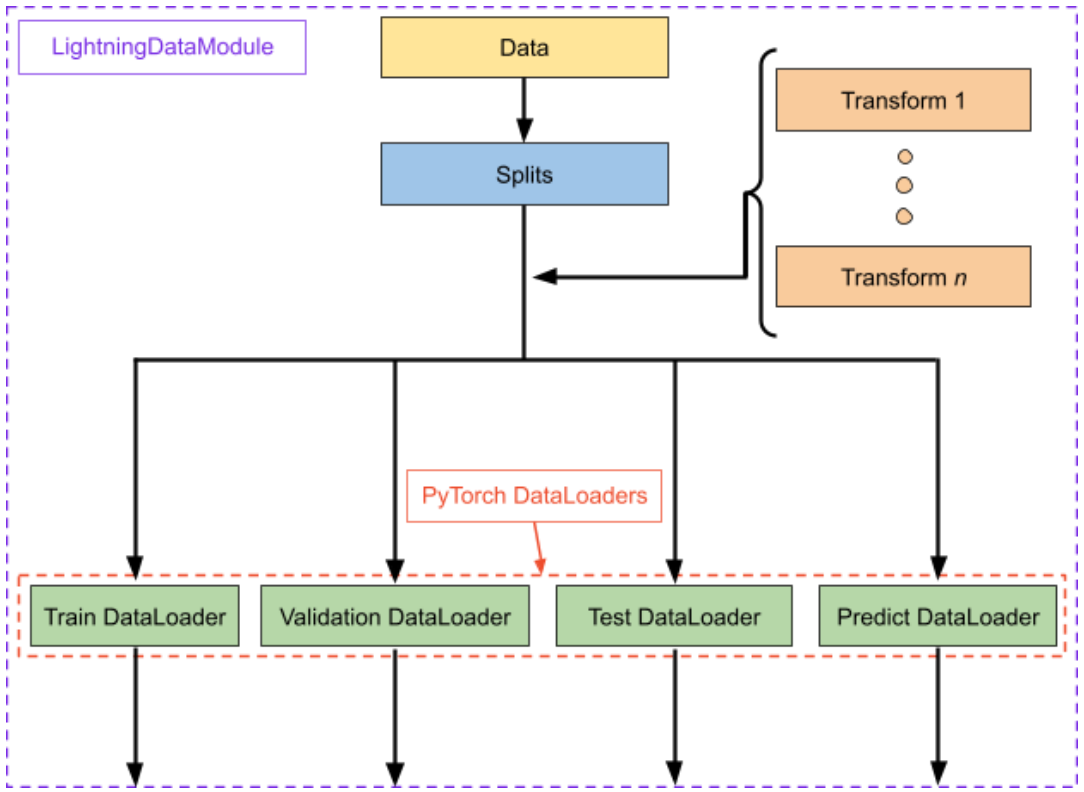

In [6]:
class ChestDataModule(LightningDataModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.batch_size = self.hparams.batch_size
        self.num_workers = self.hparams.num_workers
        
        if self.hparams.channel_size == 1:
            self.transform = {
                    'train': transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((self.hparams.image_size, self.hparams.image_size)),  # Resizing the image as the VGG only take 224 x 244 as input size
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5), std=(0.5)),
                    ]),
                    'test': transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((self.hparams.image_size, self.hparams.image_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5), std=(0.5))
                    ])
            }
        else:
            self.transform = {
                    'train': transforms.Compose([
                        transforms.Resize((self.hparams.image_size, self.hparams.image_size)),  # Resizing the image as the VGG only take 224 x 244 as input size
                        #transforms.RandomHorizontalFlip(),  # Flip the data horizontally
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ]),
                    'test': transforms.Compose([
                        transforms.Resize((self.hparams.image_size, self.hparams.image_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])
            }

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, self.hparams.image_size, self.hparams.image_size)


    def setup(self,stage=None):
        self.train_dataset  = ImageFolder(root=self.hparams.train_data_location, transform= self.transform['train'])

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          self.hparams.batch_size,
                          num_workers=self.hparams.num_workers,
                          shuffle=True,
                          pin_memory=True)


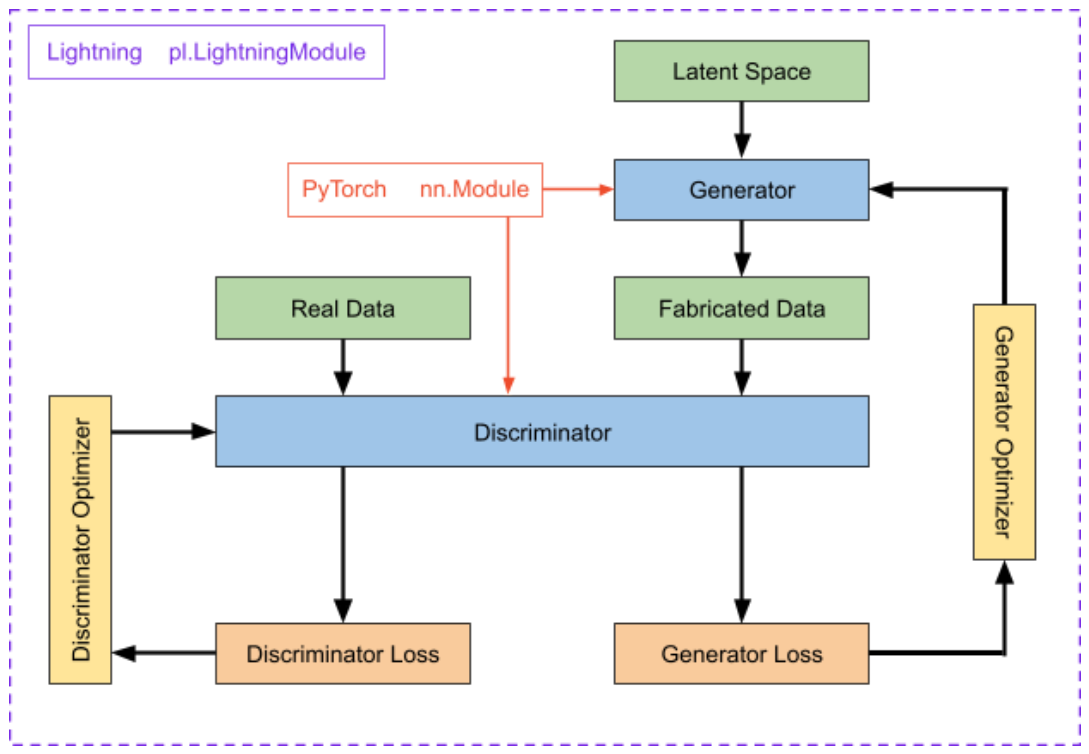

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim,channels):
        super(Generator, self).__init__()
        
        # Size of feature maps in generator
        ngf = 64
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 8, 4, 1, 0), #resim boyutunu artırmak için
            nn.BatchNorm2d(ngf * 8), # katman çıktısını normalize etmek için, mode collapse engelliyor (regülarizasyon)
            nn.ReLU(inplace=True), # vanishing gradient'i engellemek için
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, channels, 4, 2, 1),
            nn.Tanh()  # Çıktıyı [-1,1] aralığına scale etmek için kullanılır
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [8]:
class Critic(nn.Module):
    def __init__(self, channels ):
        super(Critic, self).__init__()
        # Size of feature maps in discriminator
        ndf = 64
        #self.noise = GaussianNoise()
        
        self.main = nn.Sequential(
            # input is (channels) x 64 x 64
            nn.Conv2d(channels, ndf, 4, 2, 1),
            nn.InstanceNorm2d(ndf, affine=True), # örneklerin kendi arasındaki ilişkiyi öğrenmesini istemiyoruz, bu nedenle instance
            nn.LeakyReLU(0.2, inplace=True), # vanishing gradient'i engellemek için, Critic'te relu dan daha iyi, slope 0.2
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.InstanceNorm2d(ndf * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
            nn.InstanceNorm2d(ndf * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0), # son katmanda aktivasyon yok, critic görüntünün gerçekçiliğini çıkartıyor
        )

    def forward(self, x):      
        return self.main(x)

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class WGANGP(LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        # networks
        self.generator = Generator(latent_dim=self.hparams.latent_dim,channels=self.hparams.channel_size)
                
        self.critic = Critic(channels=self.hparams.channel_size)
        
        
        print("----------GENERATOR------------")
        summary(self.generator, (self.hparams.latent_dim, 1, 1), device="cpu")
        print("----------DISCRIMINATOR------------")
        summary(self.critic, (self.hparams.channel_size, 64, 64), device="cpu")


        self.validation_z = torch.randn(64, self.hparams.latent_dim,1,1)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def compute_gradient_penalty(self, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN GP"""
        # Random weight term for interpolation between real and fake samples
        
        alpha = torch.FloatTensor(real_samples.size(0),1,1,1).uniform_(0,1)
        alpha = alpha.expand(real_samples.size(0), real_samples.size(1), real_samples.size(2), real_samples.size(3)).to(self.device)
        
        # Get random interpolation between real and fake samples, örnelenen değerler ile ara ilişkiler bulunuyor
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        interpolates = interpolates.to(self.device)
        
        d_interpolates = self.critic(interpolates)
        
        fake = torch.ones(d_interpolates.size()).to(self.device)
        
        
        #print(d_interpolates.shape, interpolates.shape)
        
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
        )[0]
        #gradients = gradients.view(gradients.size(0), -1).to(self.device)
        gradients = gradients.view(len(gradients), -1)
        gradients_norm = gradients.norm(2, dim=1)
        
        gradient_penalty = torch.mean((gradients_norm - 1)**2)
        return gradient_penalty
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch

        # rastgele gürültü vektörü örnekleniyor
        z = torch.randn((imgs.shape[0], self.hparams.latent_dim,1,1))
        z = z.type_as(imgs)
        

        # GENERATOR EĞİTİMİ
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)
           
            #calculate loss
            g_loss = -1. * torch.mean(self.critic(self(z)))

            self.log("g_loss", g_loss, prog_bar = True)
            return g_loss

        # Critic Eğitimi
        if optimizer_idx == 1:
            
            #--------------------------
            # Critic'in gerçek ve yapay görüntüler için verdiği çıktılar alınıyor
            fake_imgs = self(z)

            # Real images
            real_validity = self.critic(imgs)
            # Fake images
            fake_validity = self.critic(fake_imgs)            
            #-------------------------
            
            # Gradient penalty
            gradient_penalty = self.compute_gradient_penalty(imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.hparams.lambda_term * gradient_penalty

            self.log("d_loss",d_loss,prog_bar=True)
            self.log("d_real", -torch.mean(real_validity), prog_bar = True)
            self.log("d_fake", torch.mean(fake_validity), prog_bar = True)
            return d_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        
        # Her ağ için ayrı ayrı tanımlıyoruz
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.critic.parameters(), lr=lr, betas=(b1, b2))
        
        #optimizer'lar içerisinde hangi ağın ne sıklıkta koşacağını belirtebiliyoruz.
        return (
            {'optimizer': opt_g, 'frequency': 1},
            {'optimizer': opt_d, 'frequency': self.hparams.critic_iter}
        )

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs,normalize= True)
        #print(self.current_epoch)
        self.logger.experiment.add_image("generated_images", grid, global_step=self.current_epoch)

In [11]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="batch size")
parser.add_argument("--train_data_location", type=str, default="./chest_xray/train/PNEUMONIA",help="train dataset location")
parser.add_argument("--val_data_location", type=str, default="./chest_xray/val/PNEUMONIA",help="validation dataset location")
parser.add_argument("--test_data_location", type=str, default="./chest_xray/test/PNEUMONIA",help="test dataset location")

parser.add_argument("--critic_iter", type=int, default=5, help="how many iters to train critic")
parser.add_argument("--lambda_term", type=int, default=10, help="grad penalty lambda term")


parser.add_argument("--max_epochs", type=int, default=1000, help="Epoch Size")
parser.add_argument("--image_size", type=int, default=64, help="Spatial size of training images")
parser.add_argument("--channel_size", type=int, default=3, help="channel size")

# When using distributed training (DDP, not DP) make sure to modify your learning rate according to your effective batch size.
parser.add_argument("--gpus", type=int, default=2, help="Number of GPUs. Use 0 for CPU mode")
parser.add_argument("--num_workers", type=int, default=6, help="Number of cores to be used.")

parser.add_argument("--lr", type=int, default=1e-4,help="learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="Beta1 hyperparameter for Adam optimizer")
parser.add_argument("--b2", type=float, default=0.999, help="Beta2 hyperparameter for Adam optimizer")

parser.add_argument("--sch_step", type=int, default=2000, help="Learning rate scheduler step size")
parser.add_argument("--sch_gamma", type=float, default=0.98, help="Learning rate scheduler gamma")

parser.add_argument("--latent_dim", type=int,default=200, help="Latent dim size")

hparams = parser.parse_args()

In [12]:
seed_everything(42, workers=True)
#init lightning model
model = WGANGP(hparams)
#init dataloader
dm = ChestDataModule(hparams)
#trainer = Trainer(gpus=2,callbacks=[TQDMProgressBar(refresh_rate=20)])

checkpoint_callback = ModelCheckpoint(
        filename='model-{epoch:02d}',
        verbose=False
    )
trainer = Trainer(gpus=1,
                  callbacks=[TQDMProgressBar(refresh_rate=20),checkpoint_callback],
                  weights_summary=None,
                  max_epochs = hparams.max_epochs)
trainer.fit(model, dm)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


----------GENERATOR------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,638,912
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
       

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: 0it [00:00, ?it/s]

# Inference

In [87]:
checkpoint_path = "./lightning_logs/version_12/checkpoints/model-epoch=999.ckpt"
#checkpoint_path = "./lightning_logs/version_11/checkpoints/model-epoch=499.ckpt"

model = WGANGP.load_from_checkpoint(checkpoint_path=checkpoint_path)
model.eval()

----------GENERATOR------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,638,912
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
       

WGANGP(
  (generator): Generator(
    (model): Sequential(
      (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (13): Tanh()
    )
  )
  

In [88]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

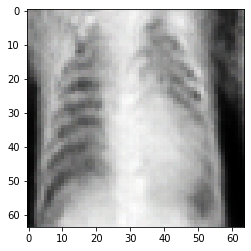

In [89]:
def generate_image(batch_size=1):
    z = torch.randn(batch_size, 200, 1, 1)
    samples = model(z)
    return samples
'''
normalize :  If True, shift the image to the range (0, 1), 
by the min and max values specified by value_range. Default: False.
'''
grid = torchvision.utils.make_grid(generate_image(1),normalize= True)
plt.imshow(grid.permute(1, 2, 0))

#görüntüyü kaydedelim
torchvision.utils.save_image(grid, 'deneme_pneumonia.png')

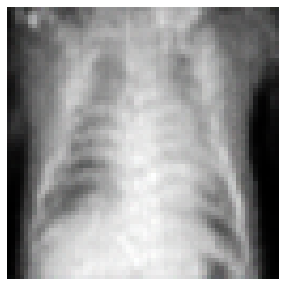

In [90]:
#%%capture
img_list = []
for i in range(64):
    img_list.append(torchvision.utils.make_grid(generate_image(),normalize= True))

fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Gerçek Görüntülerle Kıyaslayalım

In [91]:
import yaml

#eğitimde kullanılan hyperparametreler
#yaml_path = './lightning_logs/version_12/hparams.yaml'
yaml_path = './lightning_logs/version_11/hparams.yaml'

with open(yaml_path) as f:
    # use safe_load instead load
    hparams  = yaml.safe_load(f)
print(hparams)
    
#Dataloader'ı hazırlayalım
data_loaders  = ChestDataModule(hparams)
data_loaders.setup()
val_loader = data_loaders.train_dataloader()

it = iter(val_loader)
real_image_list = []
for i in range(2):
    im,_ = next(it)
    for i in im:
        real_image_list.append(torchvision.utils.make_grid(i,normalize= True))

{'b1': 0.5, 'b2': 0.999, 'batch_size': 64, 'channel_size': 3, 'critic_iter': 5, 'gpus': 2, 'image_size': 64, 'lambda_term': 10, 'latent_dim': 200, 'lr': 0.0001, 'max_epochs': 500, 'num_workers': 6, 'sch_gamma': 0.98, 'sch_step': 2000, 'test_data_location': './chest_xray/test/PNEUMONIA', 'train_data_location': './chest_xray/train/PNEUMONIA', 'val_data_location': './chest_xray/val/PNEUMONIA'}


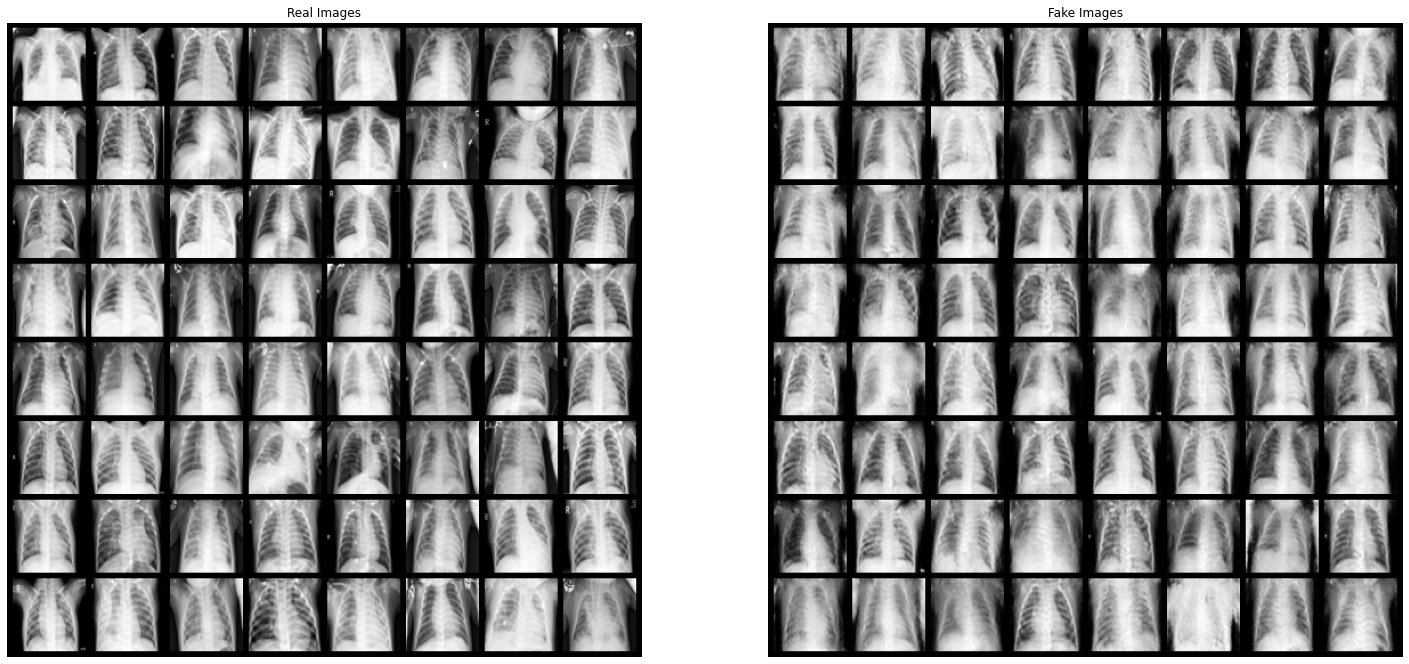

In [92]:
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_image_list[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(img_list[:64], padding=5, normalize=True),(1,2,0)))
plt.show()